![Tweeting](images/MillenialTwitter.jpg)

# How Do You Measure Word of Mouth?

## Tweet Sentiment Analysis Using NLP

The objective of this project is to explore the numerous Natural Language Processing tools currently available to see what performs most effectively in attempting to do two things: 1) Extracting essential pieces of information from tweets and 2) determine the sentiment of these tweets. The business applications for these tools are endless, but the main focus of the project is to build a pipeline for processing large amounts of text data given a reasonable training dataset. Using these models, we can measure the impact of marketing campaigns on how much people are discussing certain products on social media and how they feel about them. While some people say all press is good press, negative word of mouth can be far more damaging than no market penetration at all. Also, tools like this can be used for gathering feedback on public perception of products and companies.

### The Data

The dataset is a collection of 9000 tweets all sent around the time of the SXSW festival regarding different products from Apple and Android, namely iPhones, iPads, Google Apps, and Apple Apps. Each tweet is tagged with the products the tweet concerns as well as 'Positive Emotion', 'Negative Emotion', 'No emotion', or 'I can't tell'. The tweets include non-ASCII characters as well as the usual quirks of social media communication. The data is extremely noisy because Twitter is a chaotic place. Some of the tweets aren't even in English, which is difficult to parse out without an effective language detector. Also, about half of the tweets have not been labeled with their correct product, so that data will not be included in the training/testing data for the entity recognition model.

### Approach

One of the challenges of NLP is deciding on both a vectorization method and how to clean the data before vectorization. There are several tools and methodologies available to approach both of these tasks. The core of Natural Language Processing is turning the text into tokens that can then be vectorized. To do this, we can either use basic REGEX extraction to find essential information, lemmatization, or we can use more advanced libraries of word embeddings such as SpaCy. For this project I will be using three vectorization methods:

    1) Bag of Words Count Vectorization
    2) Term Frequency - Inverse Document Frequency (TF-IDF) Vectorization
    3) SpaCy Doc pipeline vectorization
   
I expect there to be a large difference in the quality of these vectorization methods. Each tweet is, by definition, quite short and people tend to use punctuation and full sentences at random, which could make the SpaCy doc vectorization extremely noisy. For TF-IDF, I expect that to be more successful at identifying products, as it would make sense an iPad tweet would contain the word 'iPad' and not the word 'Google' more often than not.

### Preprocessing

However, before we vectorize, we must clean the data. Since these tweets are very noisy with special characters, websites, handles and image links, those will have to be removed. The two major choices after that would be concerning stop words (common words with no inherent entropic value) and hashtags.

In order to test the various models I created a TextSet class that will allow various preprocessing options. Hashtags are an interesting linguistic element of social media because they can be frustrating noise or they can be topic tags, meaning they are extremely useful OR extremely confounding. Take the fake tweet:

    This iPad's battery is great #justkidding #itsucks
    
Versus:

    This iPad's battery is great
 
In this case, removing the hashtags completely changes the meaning of the tweet. And so, for each of the vectorization methods, I will create one dataset without Hashtags and one with. The other major processing choice concerns stop words. The SpaCy vectorization method takes into account sentence structures and punctuation, so I will create two SpaCy datasets, one with hashtags and one without, while I will remove stop words from both the TF-IDF dataset and the Count Vectorized Dataset to measure their performance against one another.

### Model Comparison

I will be using several different multi-class classification models to solve these objects. In order to measure the accuracy of each model against all 4 datasets, I created the ModelComparison class that can produce key accuracy, precision, recall metrics for non-neural net models as well as validation and training loss charts for neural network machine learning models. I will be exploring the effectiveness of the following models on the various datasets:

- Gridsearch Support Vector Machine using 'rbf' and 'sigmoid' kernels
- Gridsearch polynomial kernal for a Support Vector Machine
- Gridsearch Random Forest Classifier
- Complement Naive Bayes (only on TF-IDF and Count vectorized models)
- Multinomial Naive Bayes (only on TF-IDF and Count vectorized models)
- Tensorflow Sequential Neural Network

So, let's take a look at the data and define baselines for model validation.

## Part 1: Load and Clean Data

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk import word_tokenize, FreqDist
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn import svm
import matplotlib.pyplot as plt
import spacy
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Dropout, Layer
import time
import warnings
from utils import TextSet, ModelComparison, process_text

warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(16)

In [2]:
def process_text(text, is_spacy=False, keep_stopwords=True, keep_links=False, keep_hashtags = True):
    
    '''
    Processes, cleans, and tokenizes text with multiple options on how to do so. Returns either a SpaCy doc object or a list of tokens
    
    Parameters
    ----------
    text - (str) - the text to be processed
    is_spacy - (bool) - whether or not the return is a SpaCy doc with stop words included. If True is passed, keep_stopwords will be ignored
    keep_stopwords - (bool) - whether or not to remove stopwords using the nltk stopwords library
    keep_links - (bool) - whether or not to turn a handle and website link into a blank word such as WEBSITE for the purposes of sentence structure vectorization
    keep_hashtags - (bool) - whether or not to simply remove the # symbol from a hashtag or remove the hashtag completely
    
    Returns
    -------
    Processed text - doc, if OR list
    
    '''
    
    if keep_links == True: # Removes all {links} as well as urls and @handles which sometimes include a preceeding period
        text = re.sub('\.?(@[A-Za-z0-9_]+)', 'HANDLE', text)
        text = re.sub('{([A-Za-z]+)}', 'WEBSITE', text)
        text = re.sub('(http://[A-Za-z./0-9?=-]+)', 'WEBSITE', text)
    else:
        text = re.sub('\.?(@[A-Za-z0-9_]+)', '', text)
        text = re.sub('{([A-Za-z]+)}', '', text)
        text = re.sub('(http://[A-Za-z./0-9?=-]+)', '', text)
    
    if keep_hashtags == False: # Either removes the complete hashtag or just the '#' symbol
        text = re.sub('(#[A-Za-z0-9_]+)', '', text)
    else:
        text = text.replace('#', '')
        
    text = re.sub('&([A-Za-z])+;', '', text) # Removes special html characters such as &quot
    text = re.sub('(\s){2,}', ' ', text) # Turns double/triple spaces into single spaces
    text = text.replace('RT', '') # Removes if the tweets have been retweeted
    text = text.replace('\x89Û÷', '') # Removes special characters
    text = text.replace('\x89Ûª', '')
    text = text.replace('\x89ÛÏ', '')
    text = text.replace('\x9d', '')
    text = text.replace('\x89Û', '')
    text = text.replace('\x89ÛÒ', '')
    text = text.replace('[pic]', '') # Removes picture links
    text = text.replace('(\\x89)(\S)*', '')
    doc = nlp(text) # Turns the resulting string into a SpaCy doc object
    
    if is_spacy == True:
        return doc
    
    text = text.replace("'", '') # Removes apostrophes
    
    if keep_stopwords == False: # Makes all tokens lower case, removes punctuation and stopwords
        return [x.lower() for x in list([token.text for token in doc if token.is_punct == False and token.text.lower() not in stopwords_list])]
    else: # Does the same thing, but keeps stopwords in
        return [x.lower() for x in list([token.text for token in doc if token.is_punct == False])]

class TextSet:

    
    def __init__(self, X, y, name=None, is_spacy=False, keep_stopwords=False, keep_links=False, keep_hashtags=False, random_seed=42, split=.3):
        '''

        Constructs necessary attributes for the Model_Analysis object and automatically processes the X data into Holdout, 
        Train and Test sets ready for vectorization. Also proceses y into labels and sparse OHE matrices, split into Holdout, 
        Train, and Test sets. The Holdout set is 10% of the original test data.

        Parameters:
        ----------

        X : Series or Array
            The text that will be processed in a fashion determined by the other arguments. It will be split into holdout, train, and test batches for testing. 
        y : Series or Array
            The target values for the accompanying texts passed in X. Will be processed with both a label encoder and a one hot encoded sparse matrix. Must be the same dimensions as X.
        name : String
            The name of the TextSet. Used for labeling purposes during analysis.
        is_spacy : Boolean
            Whether or not the text will be processed into a SpaCy doc and will use the SpaCy vectorization method.
        keep_stopwords: Boolean
            Whether or not the processed text will include stop words
        keep_links: Boolean
            If True is passed, Twitter handles and Web URLs will be replaced with dummy words. If False, then the links will be removed completely
        keep_hashtags: Boolean
            If True is passed, the hashtag symbol will be removed, but the rest of the hashtag will remain. If False, then the entire hashtag will be removed.
        random_seed: int
            The random state used for partitioning data
        split: float
            The size of the test set when splitting data into train and test

        '''

        self.X = X
        self.y = y
        self.name = name
        self.is_spacy = is_spacy
        self.keep_stopwords = keep_stopwords
        self.keep_links = keep_links
        self.keep_hashtags = keep_hashtags
        self.random_seed = random_seed
        self.split = split
        self.process_data()
            
    def process_data(self):
        '''
        Takes X and y and tokenizes the text based on the methods determined by the class's parameters. 
        The data is then split into a 10% holdout group, train, and test groups. The target y variable is 
        processed into labels and one hot encoded sparse matricies.
        
        Parameters
        ----------
        
        None
        
        Returns
        -------
        text : List
            A list of all processed tokens in the X column
        X_holdout_tokens : List
            Tokenized list of the X holdout group
        X_train_tokens : List
            Tokenized list of the X train group
        X_test_tokens : List
            Tokenized list of the X test group
        y_holdout_ohe : Array
            A sparse matrix of the y holdout group
        y_holdout_l : Array
            A 1D labeled array of the y train group
        y_train_ohe : Array
            A sparse matrix of the y train group
        y_train_l : Array
            A 1D labeled array of the y train group
        y_test_ohe : Array
            A sparse matrix of the y test group
        y_test_l : Array
            A 1D labeled array of the y test group
        y_ohe : OneHotEncoder
            The one hot encoder used to transform y values into sparse matricies
        y_labeler : LabelEncoder
            The label encoder used to transform the y values into the labels fo testing
        process_time 
        : int
            Amount of time in seconds for text to process
        '''
        start_time = time.time()
        
        self.tokens = [process_text(tweet, 
                                    is_spacy=self.is_spacy, 
                                    keep_stopwords=self.keep_stopwords, 
                                    keep_links=self.keep_links, 
                                    keep_hashtags=self.keep_hashtags) for tweet in self.X]
        
        
        X_processed, self.X_holdout_tokens, y_processed, self.y_holdout = train_test_split(self.tokens, 
                                                                              self.y, 
                                                                              random_state=self.random_seed, 
                                                                              test_size=.1)
        
        self.X_train_tokens, self.X_test_tokens, self.y_train, self.y_test = train_test_split(X_processed, 
                                                                              y_processed, 
                                                                              random_state=self.random_seed, 
                                                                              test_size=self.split)
        
        if self.is_spacy == True:
            token_list = []
            for doc in self.tokens:
                token_list.append([token.text for token in doc])
            self.tokens = token_list
            
        self.text = [' '.join(x) for x in self.tokens]
        
        encoder = OneHotEncoder()
        self.y_train_ohe = encoder.fit_transform(np.array(self.y_train).reshape(-1,1))
        self.y_test_ohe = encoder.transform(np.array(self.y_test).reshape(-1,1))
        self.y_holdout_ohe = encoder.transform(np.array(self.y_holdout).reshape(-1,1))
        self.y_ohe = encoder
        
        labeler = LabelEncoder()
        self.y_train_l = labeler.fit_transform(self.y_train)
        self.y_test_l = labeler.transform(self.y_test)
        self.y_holdout_l = labeler.transform(self.y_holdout)
        self.y_labeler = labeler
        
        self.y_train_ohe = self.y_train_ohe.toarray()
        self.y_test_ohe = self.y_test_ohe.toarray()
        self.y_holdout_ohe = self.y_holdout_ohe.toarray()
        self.process_time = time.time() - start_time
        
        print("--- %s seconds ---" % (self.process_time))
        
        
    def word_cloud(self):
        
        '''
        Visualizes the entire corpus of X into a frequency wordcloud
        
        Parameters
        ----------
        
        None
        
        Returns
        -------
        
        wordcloud : WordCloud
            A visualization of the wordcloud on a (6,6) graph
        '''

        words = ' '.join(self.text)

        self.wordcloud = WordCloud(width = 600, height = 600,
                        background_color ='white',
                        min_font_size = 10).generate(words)

        # plot the WordCloud image                       
        plt.figure(figsize = (6, 6), facecolor = None)
        plt.imshow(self.wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.title(f'Word Cloud For {self.name}')
        plt.show()
        
    
    def plot_frequency(self, num_words = 50):
        
        '''
        Creates a bar graph of the frequencies of each token in the complete corpus of X
        
        Parameters
        ----------
        
        num_words : int
            Number of words to be displayed
            
        Returns
        -------
        
        Bar Plot : graph
            A bar plot of the most frequent words in the X corpus
        '''
    
        data_concat = []

        for tweet in self.tokens:
            data_concat += tweet

        data_freqdist = FreqDist(data_concat)

        x = []
        y = []

        for token in data_freqdist.most_common(num_words):
            x.append(token[0])
            y.append(token[1])

        plt.figure(figsize=(15, 6))
        plt.bar(x=x, height=y)
        plt.xticks(rotation=45)
        plt.xlabel('Words')
        plt.title(f'{self.name} {num_words} Most Common Words')
        plt.ylabel('Frequency')
        plt.show()
    
    def vectorize(self, method='tf_idf', max_features=300, ngram_range=(1,1)):
        
        '''
        Turns X_train, X_test, and X_holdout into vectors for processing 
        
        Parameters
        ----------
        
        method : String - 'tf_idf' or 'count'
            Method of vectorization if is_spacy is False
        max_features : int
            Number of words to be included in the count or TF-IDF vectorization
        ngram_range : tuple
            Number of words to be considered as paired for tokenization
        
        Returns
        -------
        
        X_train: Array
            A vector representation of X_train tokens
        X_test: Array
            A vector representation of X_test tokens
        X_holdout: Array
            A vector representation of X_holdout tokens
        vectorizer: CountVectorizer or TfidfVectorizer
            The vectorizer used to transform the X data
        
        '''
        
        if self.is_spacy == True:
            self.X_train = np.array([doc.vector for doc in self.X_train_tokens])
            self.X_test = np.array([doc.vector for doc in self.X_test_tokens])
            self.X_holdout = np.array([doc.vector for doc in self.X_holdout_tokens])
        
        else:
            X_train = [' '.join(x) for x in self.X_train_tokens]
            X_test = [' '.join(x) for x in self.X_test_tokens]
            X_holdout = [' '.join(x) for x in self.X_holdout_tokens]
            
            if method == 'tf_idf':
                self.vectorizor = TfidfVectorizer(max_features=max_features,ngram_range=ngram_range)
                self.X_train = self.vectorizor.fit_transform(X_train)
                self.X_test = self.vectorizor.transform(X_test)
                self.X_holdout = self.vectorizor.transform(X_holdout)
                self.X_train = self.X_train.toarray()
                self.X_test = self.X_test.toarray()
                self.X_holdout = self.X_holdout.toarray()

            elif method == 'count':
                self.vectorizor = CountVectorizer(max_features=max_features, ngram_range=(1,1))
                self.X_train = self.vectorizor.fit_transform(X_train)
                self.X_test = self.vectorizor.transform(X_test)
                self.X_holdout = self.vectorizor.transform(X_holdout)
                self.X_train = self.X_train.toarray()
                self.X_test = self.X_test.toarray()
                self.X_holdout = self.X_holdout.toarray()
                
        
    def regularize(self):
        
        '''
        Normalizes the X vectors using a StandardScaler. Ideal for usage with neural networks. Must be run after the vectorize function.
        
        Parameters
        ----------
        
        None
        
        Returns
        -------
        
        scaler: StandardScaler
            The scaler used to transform X vectors
        X_train_scaled: Array
            The scaled vector of X_train
        X_test_scaled: Array
            The scaled vector of X_test
        X_holdout_scaled: Array
            The scaled vector of X_holdout
        '''
            
        self.scaler = StandardScaler()
            
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        self.X_holdout_scaled = self.scaler.transform(self.X_holdout)

class ModelComparison:
    
    def __init__(self, pipeline, data_list, y_format='label', nn=False, name=None):
            '''

            Constructs necessary attributes for the ModelComparison object. If nn is True then y_format will be changed to 'ohe'.

            Parameters:
            ----------

            pipeline : Classifier
                An untrained classification alogorithm for comparing against data. A pipeline is recommended in order to control scaling and imputing, but a regular model can be passed.
            data_list : List
                A list of TextSet objects with X, y train, test and holdout sets already processed and vectorized
            y_format : 'label', 'ohe' or 'raw'
                The format of the y_data. If 'label' is passed, then y_train_l will be used. If 'ohe', then y_train_ohe will be used. Else, y_train tokens will be used.
            nn : Boolean
                Whether or not the pipeline is a neural network
            name : String
                The name of the ModelComparison Object.

            '''
            self.pipeline = pipeline
            self.data_list = data_list
            self.name = name
            self.y_format = y_format
            self.data_names = {j:i for (i, j) in tuple(enumerate([x.name for x in self.data_list]))}
            self.ref_dict = {dataset.name : dataset for dataset in self.data_list}
            self.nn = nn
            
            if self.nn == True:
                self.y_format = 'ohe'
    
    def set_model(self, new_model, y_change=None, nn_change=False):
        '''
        Changes the model used for comparison.
        
        Parameters
        ----------
        
        new_model : Classifier
            An untrained classification alogorithm for comparing against data.
        y_change : 'label', 'ohe', 'raw' or None
            The new configuration of the y variable
        nn_change : Boolean
            Pass True if the new model is a neural network, else pass False
        
        '''
        self.pipeline = new_model
        if y_change != None:
            self.y_format = y_change
        
        if nn_change == True:
            self.nn = nn_change

    def fit_models(self, data=None, batch_size=15, epochs=20):
        
        '''
        Fits the model to each of the datasets and produces data for comparison and visualization.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
        batch_size : int
            Size of batches used when training a Neural Network model. Ignored if nn is False.
        epochs : int
            Number of epochs used to train a Neural Network model. Ignored if nn is False.
            
        Returns
        -------
        
        data_dict : dictionary
            A dictionary with keys corresponding to the names of each dataset fit to the model. Contains all predicted y values for each dataset for visualization and comparison.
        score_comparison: dataframe
            A dataframe of scores for each dataframe with the maximum value in each row highlighted
        process_time: int
            Amount of time taken to fit the model to all datasets.
        '''
        
        start_time = time.time()
        self.data_dict = {}
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data
        
        for dataset in set_list:
            
            y_dict_train = {
                'label': dataset.y_train_l,
                'ohe': dataset.y_train_ohe,
                'raw': dataset.y_train
                }
            
            y_dict_test = {
                'label': dataset.y_test_l,
                'ohe': dataset.y_test_ohe,
                'raw': dataset.y_test
            }
            
            y_dict_holdout = {
                'label': dataset.y_holdout_l,
                'ohe': dataset.y_holdout_ohe,
                'raw': dataset.y_holdout
            }
            
            y_train = y_dict_train[self.y_format]
            y_test = y_dict_test[self.y_format]
            y_holdout = y_dict_holdout[self.y_format]
            
            if self.nn == True:
                
                model = self.pipeline.fit(dataset.X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(dataset.X_train_scaled, y_train))
                
                y_train_preds = self.pipeline.predict(dataset.X_train_scaled)
                y_test_preds = self.pipeline.predict(dataset.X_test_scaled)
                y_holdout_preds = self.pipeline.predict(dataset.X_holdout_scaled)
                
                hold_val = self.pipeline.evaluate(dataset.X_holdout_scaled, y_holdout)
            
            else:
                model = self.pipeline.fit(dataset.X_train, y_train)
                
                y_train_preds = model.predict(dataset.X_train)
                y_test_preds = model.predict(dataset.X_test)
                y_holdout_preds = model.predict(dataset.X_holdout)
            
            if self.nn==False:
                
                self.data_dict[dataset.name] = {
                    'y_train': y_train,
                    'y_test': y_test,
                    'y_holdout': y_holdout,
                    'y_train_preds': y_train_preds, 
                    'y_test_preds': y_test_preds,
                    'y_holdout_preds': y_holdout_preds,   
                }
            
            else:
                self.data_dict[dataset.name] = {
                    'y_train': y_train,
                    'y_test': y_test,
                    'y_holdout': y_holdout,
                    'y_train_preds': y_train_preds, 
                    'y_test_preds': y_test_preds,
                    'y_holdout_preds': y_holdout_preds,
                    'model_history': model.history,
                    'holdout_history': hold_val
                }
        
        if self.nn == False:
            self.calc_scores(data=set_list)
        else:
            self.calc_nn_scores(data=set_list)
        self.process_time = time.time() - start_time
        print("--- %s seconds to process ---" % (self.process_time))
    
    def calc_scores(self, data=None, data_type='test'):
        
        '''
        Calculates all major scores on each dataset for comparison for non neural network datasets. Will return an error if the model is a neural network.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
        data_type : String - 'test' or 'holdout'
            Determines the values compared in the final score comparison. If 'test', then the test scores will be compared. If 'holdout', then holdout scores will be shown.
        
        Returns
        -------
        
        all_scores : DataFrame
            All train and test scores for all datasets in a single dataframe showing scores for Accuracy, Precision, Recall and F1 Score. All values are calculated using the Macro method.
        score_comparison : DataFrame
            Test scores for each dataset compared in a single dataframe with the top value in each row highlighted.
        '''
        
        df_list = []
        
        title = data_type.title()
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data
        
        for dataset in set_list:
            
            y_train = self.data_dict[dataset.name]['y_train']
            y_train_preds = self.data_dict[dataset.name]['y_train_preds']
        
            if data_type == 'test':
                
                y_val = self.data_dict[dataset.name]['y_test']
                y_val_preds = self.data_dict[dataset.name]['y_test_preds']
            
            elif data_type == 'holdout':
            
                y_val = self.data_dict[dataset.name]['y_holdout']
                y_val_preds = self.data_dict[dataset.name]['y_holdout_preds']
            
            dictionary = {
                'Accuracy': [accuracy_score(y_train, y_train_preds), accuracy_score(y_val, y_val_preds)],
                'Precision (Macro)': [precision_score(y_train, y_train_preds, average='macro'), precision_score(y_val, y_val_preds, average='macro')],
                'Recall (Macro)': [recall_score(y_train, y_train_preds, average='macro'), recall_score(y_val, y_val_preds, average='macro')],
                'F1 (Macro)': [f1_score(y_train, y_train_preds, average='macro'), f1_score(y_val, y_val_preds, average='macro')],
            }
            
            df = pd.DataFrame.from_dict(dictionary, orient='index', columns=[f'{dataset.name} Train',f'{dataset.name} {title}'])
            
            self.data_dict[dataset.name][f'{data_type} scores'] = df
            df_list.append(df)
        
        self.all_scores = pd.concat(df_list, axis=1)
        
        self.score_comparison = self.all_scores[[x for x in self.all_scores.columns if x.endswith(title)]]
        
        self.score_comparison = self.score_comparison.style.highlight_max(color='lightgreen', axis=1)
        
    def calc_nn_scores(self, data=None):
        
        '''
        Calculates accuracy and loss scores for each dataset if the model is a neural network. Will produce an error if the model is not a neural network.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
        
        Returns
        -------
        
        score_comparison : DataFrame
            A dataframe comparing the accuracy and loss scores on the holdout data for each dataset
        '''

        df_list = []
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data

        for dataset in set_list:

            hist = self.data_dict[dataset.name]['holdout_history']

            dictionary = {
                'Loss': hist[0],
                'Accuracy': hist[1]
            }

            df = pd.DataFrame.from_dict(dictionary, orient='index', columns=[f'{dataset.name} Holdout'])

            df_list.append(df)

        self.score_comparison = pd.concat(df_list, axis=1)
            
    def compare_confusion(self, data_type='test', data=None):
        
        '''
        Plots a confusion matrix for either the Test or Holdout data for each dataset. Bear in mind, it will fit the model with all of the datsets again.
        
        Parameters
        ----------
        
        data_type : String - 'test' or 'holdout'
            Determines which dataset will be used in the confusion matrix
        data : List
            A list of processed TextSet objects. If None is passed, then the model will train on every model in the ModelComparison object
            
        Returns
        -------
        
        A confusion matrix for each dataset passed in data
        '''
        
        title = data_type.title()
        
        if data == None:
            set_list = self.data_list
        
        else:
            set_list = data
        
        for dataset in set_list:
            
            X_train = dataset.X_train
            y_train = self.data_dict[dataset.name]['y_train']
            
            self.pipeline.fit(X_train, y_train)
            
            if data_type == 'train':
                X_val = dataset.X_train
                y_val = self.data_dict[dataset.name]['y_train']
            
            elif data_type == 'test':
                X_val = dataset.X_test
                y_val = self.data_dict[dataset.name]['y_test']
                
            elif data_type == 'holdout':
                X_val = dataset.X_holdout
                y_val = self.data_dict[dataset.name]['y_holdout']
        
            plot_confusion_matrix(self.pipeline, X_val, y_val, cmap=plt.cm.Blues)
            plt.title(f'{dataset.name} {title}')
            plt.show()
        
    def plot_roc_curve(self, data_type='test', include_train=True, data=None):
        
        '''
        Plots the ROC curve for the results of the model. If a multi-class model it will return an error
        
        Parameters
        ----------
        
        data_type : String - 'test' or 'holdout'
            Determines which dataset will be used in the ROC Plot
        include_train : Boolean
            If True is passed, the ROC plot will include the training data and the validation data
        data : List
            A list of processed TextSet objects. If None is passed, then all datasets will be included in the final plot.
        
        Returns
        -------
        
        A plot of the ROC curve of the train and validation data
        '''
        
        plt.figure(figsize=(7,7))
        ax = plt.gca()
        
        if data == None:
            set_list = self.data_list
        else:
            set_list = [self.ref_dict[name] for name in data]
        
        for dataset in set_list:
            if data_type == 'test':
                y_val = self.data_dict[dataset.name]['y_test']
                y_val_preds = self.data_dict[dataset.name]['y_test_preds']
            elif data_type == 'holdout':
                y_val = self.data_dict[dataset.name]['y_holdout']
                y_val_preds = self.data_dict[dataset.name]['y_holdout_preds']
            
            fpr, tpr, threshold = roc_curve(y_val, y_val_preds)
            plt.plot(fpr, tpr, label=f'{dataset.name} {data_type}', ax=ax)
            
            if include_train == True:
                y_train = self.data_dict[dataset.name]['y_train']
                y_train_preds = self.data_dict[dataset.name]['y_train_preds']
                
                fpr, tpr, threshold = roc_curve(y_train, y_train_preds)
                plt.plot(fpr, tpr, label=f'{dataset.name} train', ax=ax)
                
                
        plt.title(f'ROC Curve for {data_type} data')
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        
    def plot_val_history(self, data=None):
        
        '''
        Plots the accuracy and loss curves for both the training and the testing data for a neural network model.
        
        Parameters
        ----------
        
        data : List
            A list of processed TextSet objects. If None is passed, then all datasets will be included in the final plots.
        
        Returns
        -------
        
        A subplot of the training and validation loss and accuracy values from the fit Neural Network model
        
        '''
        
        if data == None:
            set_list = self.data_list
        else:
            set_list = [self.ref_dict[name] for name in data]
        
        for dataset in set_list:
            history = self.data_dict[dataset.name]['model_history']
            fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12, 4))
            ax1.plot(history['val_loss'])
            ax1.plot(history['loss'])
            ax1.legend(['val_loss', 'loss'])
            ax1.set_title(f'{dataset.name} Loss')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss')

            ax2.plot(history['val_acc'])
            ax2.plot(history['acc'])
            ax2.legend(['val_acc', 'acc'])
            ax2.set_title(f'{dataset.name} Accuracy')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('Accuracy')
            plt.show()

In [3]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


As we can already see in the first few rows, keeping hashtags will probably be the better way to approach the problem, but we can see how impactful it will be in the long run. 

In [4]:
df.shape

(9093, 3)

In [5]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

That is a lot of nulls in the 'product' column. While we will be assessing sentiment first, we will need to split the known product rows from the unknown, severely limiting our dataset, which could cause issues ultimately. Also we do not have a 'No Product' tag which will make it hard to generalize this model to the larger population of tweets. We won't be concerned with that for the purposes of this project, but it is a major consideration for further iterations.

In [6]:
unknown_df = df[df['emotion_in_tweet_is_directed_at'].isna()==True]
known_df = df[df['emotion_in_tweet_is_directed_at'].isna()==False]

In [7]:
len(known_df)

3291

In [8]:
len(unknown_df)

5802

Now, let's examine the distribution of these products to determine the baseline accuracy values our models will have to beat.

In [9]:
df['emotion_in_tweet_is_directed_at'].value_counts(normalize=True)

iPad                               0.287451
Apple                              0.200851
iPad or iPhone App                 0.142814
Google                             0.130659
iPhone                             0.090246
Other Google product or service    0.089031
Android App                        0.024613
Android                            0.023701
Other Apple product or service     0.010635
Name: emotion_in_tweet_is_directed_at, dtype: float64

### Product Entity Recognition: Baseline = 28.8% Accuracy
If we blindly guess iPad, we will be right 29% of the time.

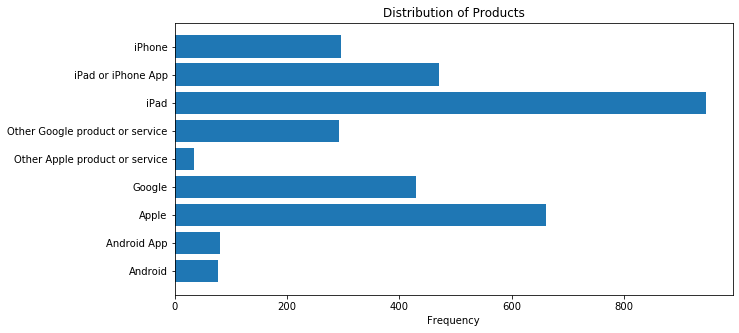

In [10]:
products = df.groupby('emotion_in_tweet_is_directed_at').count()['tweet_text']
p_labels = list(products.index)
plt.figure(figsize=(10,5))
plt.barh(y=p_labels, width=products)
plt.title('Distribution of Products')
plt.xlabel('Frequency')
plt.show()

### Sentiment Analysis: Baseline = 60.9% Accuracy

Below you can see the break down of each category into both number of entries in the dataset as well as relative frequencies.

In [11]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [12]:
df.groupby('is_there_an_emotion_directed_at_a_brand_or_product').count()

,tweet_text,emotion_in_tweet_is_directed_at
is_there_an_emotion_directed_at_a_brand_or_product,,
I can't tell,156,9
Negative emotion,570,519
No emotion toward brand or product,5388,91
Positive emotion,2978,2672


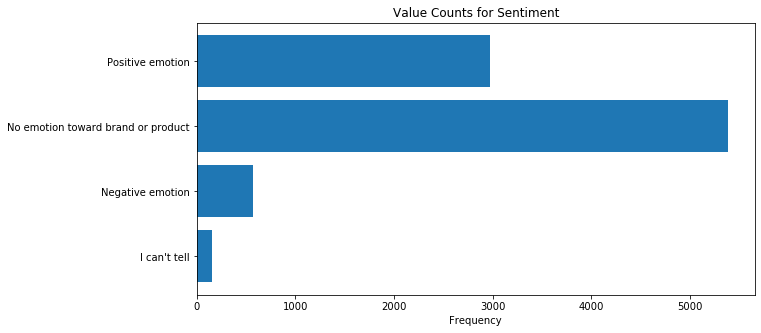

In [13]:
emotions = df.groupby('is_there_an_emotion_directed_at_a_brand_or_product').count()['tweet_text']
e_labels = list(emotions.index)
plt.figure(figsize=(10,5))
plt.barh(y=e_labels, width=emotions)
plt.title('Value Counts for Sentiment')
plt.xlabel('Frequency')
plt.show()

As you can see there are so few 'I can't tell' tweets that we might as well include those in the 'No Emotion toward Brand or Product. We also don't want to include duplicates of possibly bot-produced tweets in the dataset either.

In [14]:
df.dropna(subset=['tweet_text'],inplace=True) 

In [15]:
df.drop_duplicates(inplace=True)

Let's take a quick snapshot of the first 15 tweets to get a sense of what kind of preprocessing we have to do to remove noise:

In [16]:
for n in range(15): 
    print(df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"]['tweet_text'].iloc[n])

Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh
ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow
Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw
The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw
Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link}
SYD #SXSW crew your iPhone extra juice pods have been procured.
Why Barry Diller thinks iPad only content is nuts @mention #SXSW {link}
Gave into extreme temptation at #SXSW and bought an iPad 2... #impulse
Catch 22Û_ I mean iPad 2 at #SXSW : {link}
Forgot my iPhone for #sxsw. Android only. Knife to a gun fight
Kawasaki: key to enchantment = trustworthiness of Zappos + likeability of Richard Branson + product of Apple #sxsw #mccannsxs

As you can see we have plenty of strange symbols, non-unicode characters, website links, hashtags and even some Spanish tweets! Let's start processing these tweets into our 4 datasets.

![Word of Mouth](images/word-of-mouth-og.jpg)

## Part 2: Preprocessing and Vectorization

As stated above, I will be comparing the performance of four different datasets on each of our possible classifiers.

- TF-IDF Vectorization with Hastags included
- SpaCy Doc2Vec Vectorization with Hashtags included
- SpaCy Doc2Vec Vectorization with Hashtags excluded
- Count Vectorization with Hashtags excluded

Since the Sentiment Analysis dataset is larger, we will tackle that objective first. As mentioned, we will combine both the 'I can't tell' and 'No Emotion toward brand or product' to give us a majority class of **60.9%**. This is the number for us to beat.

In [17]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].replace("I can't tell", "No emotion toward brand or product", inplace=True)

In [18]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True)

No emotion toward brand or product    0.609813
Positive emotion                      0.327453
Negative emotion                      0.062734
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [19]:
df[df['emotion_in_tweet_is_directed_at'].isna()==True]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


### Process_Text Function

Below you will see the function used to process the texts. It is included in the TextSet class, but it is useful for showing how the text will be processed. Before anything we will define stopwords using the NLTK stop word library and we will be using the SpaCy basic pipeline *nlp* with the small English vocabulary loaded:

In [20]:
nlp = spacy.load("en_core_web_sm")

stopwords_list = stopwords.words('english') + [' ', '  ', '   ', 'w/']

In [21]:
def process_text(text, is_spacy=False, keep_stopwords=True, keep_links=False, keep_hashtags = True):
    
    '''
    Processes, cleans, and tokenizes text with multiple options on how to do so. Returns either a SpaCy doc object or a list of tokens
    
    Parameters
    ----------
    text - (str) - the text to be processed
    is_spacy - (bool) - whether or not the return is a SpaCy doc with stop words included. If True is passed, keep_stopwords will be ignored
    keep_stopwords - (bool) - whether or not to remove stopwords using the nltk stopwords library
    keep_links - (bool) - whether or not to turn a handle and website link into a blank word such as WEBSITE for the purposes of sentence structure vectorization
    keep_hashtags - (bool) - whether or not to simply remove the # symbol from a hashtag or remove the hashtag completely
    
    Returns
    -------
    Processed text - doc, if OR list
    
    '''
    
    if keep_links == True: # Removes all {links} as well as urls and @handles which sometimes include a preceeding period
        text = re.sub('\.?(@[A-Za-z0-9_]+)', 'HANDLE', text)
        text = re.sub('{([A-Za-z]+)}', 'WEBSITE', text)
        text = re.sub('(http://[A-Za-z./0-9?=-]+)', 'WEBSITE', text)
    else:
        text = re.sub('\.?(@[A-Za-z0-9_]+)', '', text)
        text = re.sub('{([A-Za-z]+)}', '', text)
        text = re.sub('(http://[A-Za-z./0-9?=-]+)', '', text)
    
    if keep_hashtags == False: # Either removes the complete hashtag or just the '#' symbol
        text = re.sub('(#[A-Za-z0-9_]+)', '', text)
    else:
        text = text.replace('#', '')
        
    text = re.sub('&([A-Za-z])+;', '', text) # Removes special html characters such as &quot
    text = re.sub('(\s){2,}', ' ', text) # Turns double/triple spaces into single spaces
    text = text.replace("'", '') # Removes apostrophes
    text = text.replace('RT', '') # Removes if the tweets have been retweeted
    text = text.replace('\x89Û÷', '') # Removes special characters
    text = text.replace('\x89Ûª', '')
    text = text.replace('\x89ÛÏ', '')
    text = text.replace('\x9d', '')
    text = text.replace('\x89Û', '')
    text = text.replace('\x89ÛÒ', '')
    text = text.replace('[pic]', '') # Removes picture links
    text = text.replace('(\\x89)(\S)*', '')
    doc = nlp(text) # Turns the resulting string into a SpaCy doc object
    
    if is_spacy == True:
        return doc
    
    if keep_stopwords == False: # Makes all tokens lower case, removes punctuation and stopwords
        return [x.lower() for x in list([token.text for token in doc if token.is_punct == False and token.text.lower() not in stopwords_list])]
    else: # Does the same thing, but keeps stopwords in
        return [x.lower() for x in list([token.text for token in doc if token.is_punct == False])]

Below you will see the loading and processing of the following datasets.

- TF-IDF Vectorization with Hastags included
- SpaCy Doc2Vec Vectorization with Hashtags included
- SpaCy Doc2Vec Vectorization with Hashtags excluded
- Count Vectorization with Hashtags excluded

The TextSet class already splits the data into a holdout, train and test set and provides two processing methods for our y values to make them compatible with all methods of Classification, label encoded for SVM and Naive Bayes, one hot encoded matrices for Neural Networks.

In [22]:
hashtags = TextSet(df['tweet_text'], 
                   df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                   name='Hashtags',  
                   keep_hashtags=True, 
                   random_seed=42, 
                   split=.3)

--- 47.56792902946472 seconds ---


In [23]:
spacy_1 = TextSet(df['tweet_text'], 
                  df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                  name = 'SpaCy No Hash',
                  is_spacy=True, 
                  keep_stopwords=True, 
                  random_seed=42, 
                  split=.3)

--- 42.57582211494446 seconds ---


In [24]:
spacy_2 = TextSet(df['tweet_text'], 
                  df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                  name = 'SpaCy w/ Hash',
                  is_spacy=True, 
                  keep_stopwords=True,
                  keep_hashtags=True,
                  random_seed=42, 
                  split=.3)

--- 44.007627964019775 seconds ---


In [25]:
no_hash = TextSet(df['tweet_text'], 
                   df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                   name='No Hashtags', 
                   random_seed=42, 
                   split=.3)

--- 42.514076948165894 seconds ---


In [26]:
datasets = [hashtags, spacy_1, spacy_2, no_hash]
no_spacy = [hashtags, no_hash]

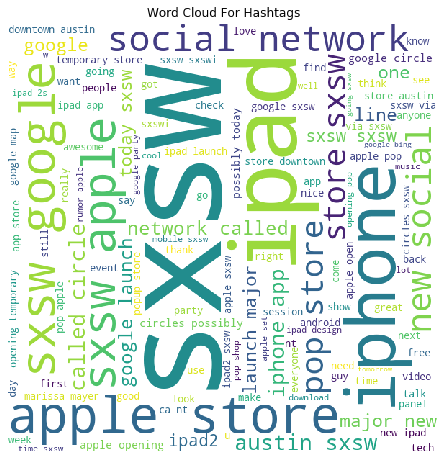

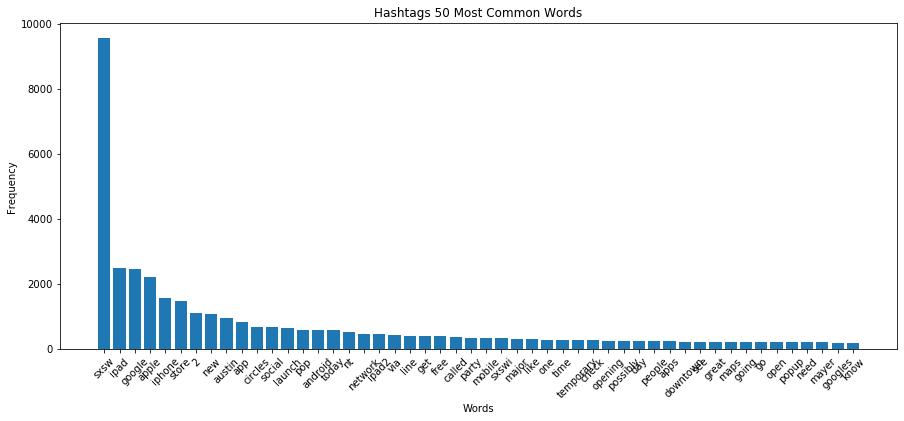

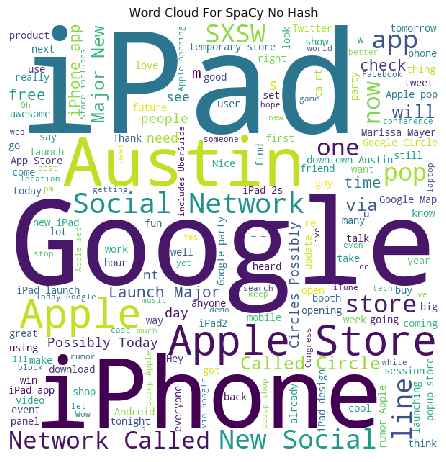

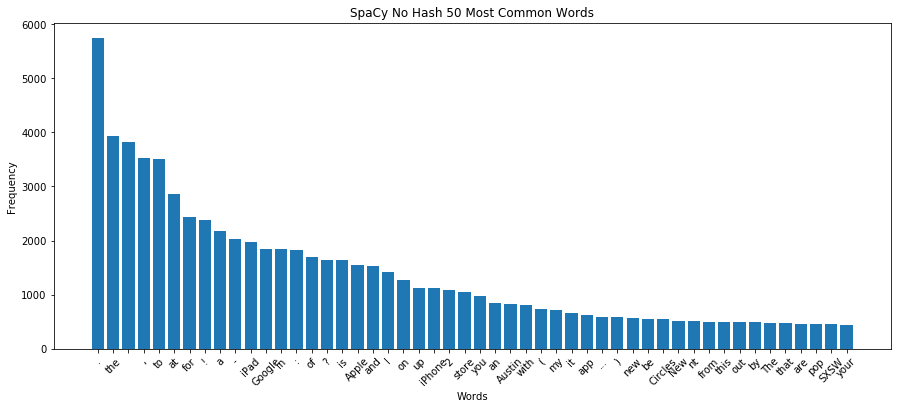

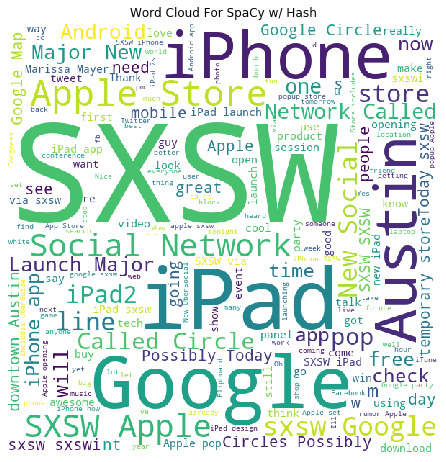

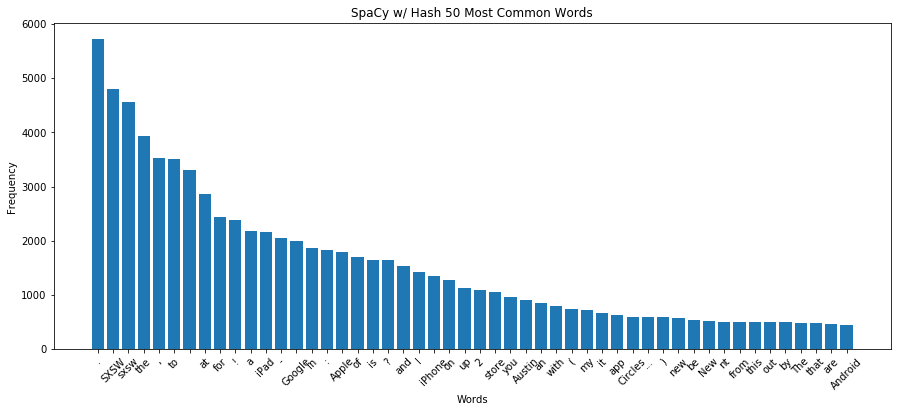

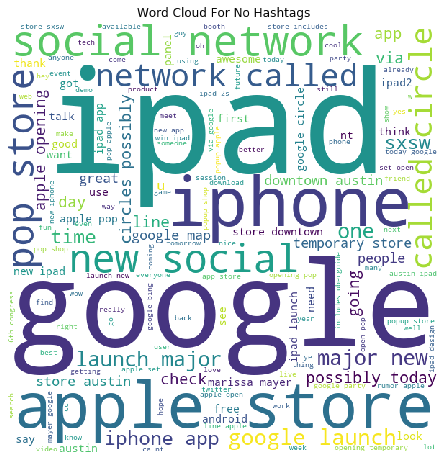

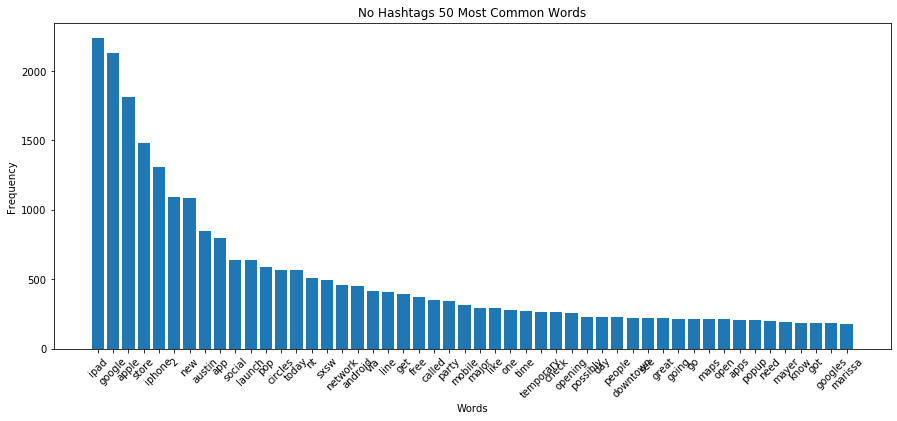

In [27]:
for data in datasets:
    data.word_cloud()
    data.plot_frequency()

### Observations

As you can see the frequency distributions and word clouds can differ greatly between datasets. You'll notice with the SpaCy datasets that there are multi-word phrases such as Apple Store. Also the hashtag #SXSW is used more than any other word, so removing hashtags massively alters the word distributions.

Now, we have to vectorize each dataset. The default method for non-SpaCy datasets is TF-IDF with 300 features, though that can be altered as needed. The SpaCy datasets default to the Doc2Vec method in the SpaCy doc object.

In [28]:
hashtags.vectorize()

In [29]:
spacy_1.vectorize()

In [30]:
spacy_2.vectorize()

In [31]:
no_hash.vectorize(method='count')

## Part 3: Sentiment Analysis

Now that we have our datasets, we can feed them into our various models to compare how they do. First I will be comparing only test scores and then I will test holdout scores between the best models. Since the datatypes required for neural networks are fairly different from these other classifiers, I will compare those after tuning the non-neural networks to maximize accuracy.

### Non Neural Network Models

Here are the models we will be testing. Keep in mind, some of these cells take a lot time to run. I recommend skipping the random forest cells.

- Support Vector Machine Gridsearch
- Polynomial Support Vector Machine Gridsearch
- Random Forest
- Complement Naive Bayes
- Multinomial Naive Bayes

In [32]:
svm_pipe = Pipeline([('scaler', StandardScaler()), ('rbf', svm.SVC())])

grid = {
    'rbf__kernel': ['rbf', 'sigmoid'],
    'rbf__gamma': ['scale'],
    'rbf__C': [1, 1e12],
    'rbf__decision_function_shape': ['ovo','ovr']
}

svm_grid = GridSearchCV(svm_pipe, param_grid=grid, scoring='accuracy', cv=5)
svm_compare = ModelComparison(pipeline=svm_grid, data_list=datasets, y_format='label', name='svm')

In [33]:
poly_pipe = Pipeline([('scaler', StandardScaler()), ('poly', svm.SVC())])

grid = {
    'poly__kernel': ['poly'],
    'poly__degree': [3, 4, 5],
    'poly__gamma': ['auto'],
    'poly__decision_function_shape': ['ovo','ovr']
}

poly_grid = GridSearchCV(poly_pipe, param_grid=grid, scoring='accuracy', cv=5)
poly_compare = ModelComparison(pipeline=poly_grid, data_list=[hashtags, spacy_1], y_format='label', name='poly')

In [34]:
cnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('cnb', ComplementNB())])
cnb_compare = ModelComparison(pipeline=cnb_pipe, data_list=no_spacy, y_format='label', name='cnb')

In [35]:
mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('mnb', MultinomialNB())])
mnb_compare = ModelComparison(pipeline=mnb_pipe, data_list=no_spacy, y_format='label', name='mnb')

In [36]:
rf_pipe = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])

grid = {
    'rf__n_estimators': [25, 50, 100],
    'rf__criterion': ['gini','entropy'],
    'rf__max_depth': [5, 7, 9],
    'rf__max_features': [5, 8, None],
    'rf__min_samples_leaf': [3, 5, 10],
    'rf__random_state': [42]
}

rf_grid = GridSearchCV(rf_pipe, param_grid=grid, scoring='accuracy', cv=5)
rf_compare = ModelComparison(pipeline=rf_grid, data_list=datasets, y_format='label', name='rf')

In [37]:
svm_compare.fit_models()
svm_compare.score_comparison

--- 554.4872062206268 seconds to process ---


,Hashtags Test,SpaCy No Hash Test,SpaCy w/ Hash Test,No Hashtags Test
Accuracy,0.670478,0.644345,0.643528,0.668028
Precision (Macro),0.720947,0.408309,0.405924,0.661666
Recall (Macro),0.427755,0.397422,0.396976,0.430052
F1 (Macro),0.426585,0.38206,0.381482,0.431314


In [38]:
svm_compare.calc_scores(data_type='holdout')

In [39]:
svm_compare.score_comparison

,Hashtags Holdout,SpaCy No Hash Holdout,SpaCy w/ Hash Holdout,No Hashtags Holdout
Accuracy,0.69129,0.67806,0.689085,0.68688
Precision (Macro),0.780238,0.430235,0.776801,0.611137
Recall (Macro),0.438065,0.418686,0.431013,0.434494
F1 (Macro),0.442035,0.409917,0.429046,0.437919


In [40]:
poly_compare.fit_models()
poly_compare.score_comparison

--- 222.86327385902405 seconds to process ---


,Hashtags Test,SpaCy No Hash Test
Accuracy,0.632095,0.622703
Precision (Macro),0.586477,0.44075
Recall (Macro),0.410854,0.367584
F1 (Macro),0.415803,0.338963


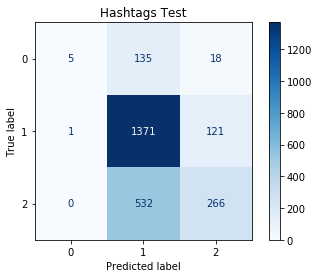

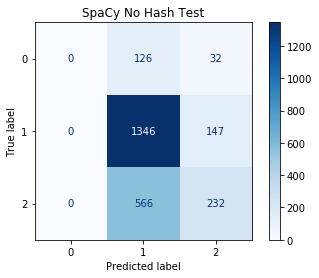

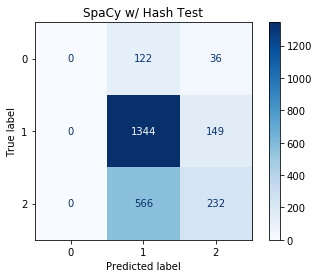

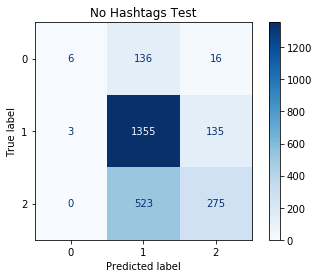

In [41]:
svm_compare.compare_confusion()

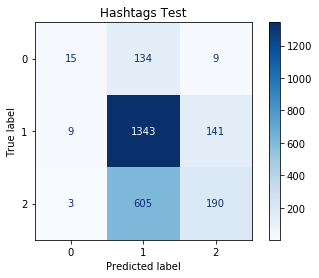

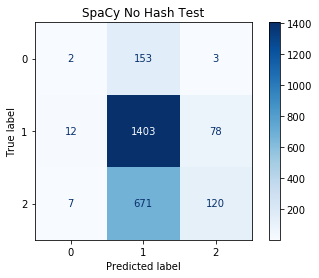

In [42]:
poly_compare.compare_confusion()

In [43]:
cnb_compare.fit_models()
cnb_compare.score_comparison

--- 0.12155604362487793 seconds to process ---


,Hashtags Test,No Hashtags Test
Accuracy,0.546345,0.532871
Precision (Macro),0.459053,0.447856
Recall (Macro),0.495874,0.479016
F1 (Macro),0.45676,0.441092


In [44]:
mnb_compare.fit_models()
mnb_compare.score_comparison

--- 0.12468385696411133 seconds to process ---


,Hashtags Test,No Hashtags Test
Accuracy,0.651286,0.643528
Precision (Macro),0.51229,0.523021
Recall (Macro),0.411019,0.427527
F1 (Macro),0.402957,0.434974


In [45]:
rf_compare.fit_models()
rf_compare.score_comparison

--- 7799.7600729465485 seconds to process ---


,Hashtags Test,SpaCy No Hash Test,SpaCy w/ Hash Test,No Hashtags Test
Accuracy,0.64067,0.636586,0.636586,0.635361
Precision (Macro),0.419857,0.417196,0.427593,0.527639
Recall (Macro),0.383941,0.374514,0.371597,0.380144
F1 (Macro),0.3611,0.343907,0.337199,0.357161


In [ ]:
rf_compare.compare_confusion()
rf_compare.calc_scores(data_type='holdout')
rf_compare.score_comparison

## Observations

Out of these first attempts, the SVM is the best model by far but takes a long time to process. The Complement Naive Bayes does fairly well on the TF-IDF with hashtags included and processes much faster. Thats said, it's clear that the TF-IDF vectorization method is far more accurate than the SpaCy Doc2Vec.

## Tuning TF-IDF and Count Vectorizers

With both TF-IDF and Count vectorizors we can tune them to possibly improve the models. We have two tuning options:

- Play with number of features included (300 is default, try 200 and 400)
- Play with ngram size - Apple, Store vs. Apple Store

In order to test the effectiveness of these vectorization methods, we'll need to process our text again into new instances of the TextSet class.

In [ ]:
hashtags_200 = TextSet(df['tweet_text'], 
                   df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                   name='Hash200',  
                   keep_hashtags=True, 
                   random_seed=42, 
                   split=.3)

In [ ]:
hashtags_400 = TextSet(df['tweet_text'], 
                   df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                   name='Hash400',  
                   keep_hashtags=True, 
                   random_seed=42, 
                   split=.3)

In [ ]:
hashtags_2 = TextSet(df['tweet_text'], 
                   df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                   name='Hash2n',  
                   keep_hashtags=True, 
                   random_seed=42, 
                   split=.3)

In [ ]:
hashtags_3 = TextSet(df['tweet_text'], 
                   df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                   name='Hash3n',  
                   keep_hashtags=True, 
                   random_seed=42, 
                   split=.3)

In [ ]:
hashtags_final = TextSet(df['tweet_text'], 
                   df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                   name='HashFinal',  
                   keep_hashtags=True, 
                   random_seed=42, 
                   split=.3)

In [ ]:
hashtags_200.vectorize(max_features=200)
hashtags_400.vectorize(max_features=400)
hashtags_2.vectorize(ngram_range=(1,2))
hashtags_3.vectorize(ngram_range=(1,3))

In [ ]:
hash_test = [hashtags_200, hashtags_400, hashtags_2, hashtags_3]

In [ ]:
cnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('cnb', ComplementNB())])
cnb_compare_2 = ModelComparison(pipeline=cnb_pipe, data_list=hash_test, y_format='label', name='cnb')

In [ ]:
cnb_compare_2.fit_models()

In [ ]:
cnb_compare_2.score_comparison

In [ ]:
mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('mnb', MultinomialNB())])
mnb_compare_2 = ModelComparison(pipeline=mnb_pipe, data_list=hash_test, y_format='label', name='mnb')

In [ ]:
mnb_compare_2.fit_models()
mnb_compare_2.score_comparison

In [ ]:
hashtags_final.vectorize(max_features=500, ngram_range=(1,2))

In [ ]:
mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('mnb', MultinomialNB())])
mnb_compare_3 = ModelComparison(pipeline=mnb_pipe, data_list=[hashtags_final], y_format='label', name='mnb')

In [ ]:
mnb_compare_3.fit_models()
mnb_compare_3.all_scores

In [ ]:
mnb_compare_3.calc_scores(data_type='holdout')
mnb_compare_3.all_scores

In [ ]:
hashtags_200.vectorize(method='count', max_features=200)
hashtags_400.vectorize(method='count', max_features=400)
hashtags_2.vectorize(method='count', ngram_range=(1,2))
hashtags_3.vectorize(method='count', ngram_range=(1,3))

In [ ]:
count_list = [hashtags_200, hashtags_400, hashtags_2, hashtags_3]

In [ ]:
mnb_compare_4 = ModelComparison(pipeline=mnb_pipe, data_list=count_list, y_format='label', name='mnb')
mnb_compare_4.fit_models()
mnb_compare_4.score_comparison

In [ ]:
mnb_compare_4.calc_scores(data_type='holdout')
mnb_compare_4.score_comparison

In [ ]:
mnb_compare_4.compare_confusion(data_type='holdout')

## Observations

In the end, tuning the number of features didn't increase the score by much. Let's see if we can improve our accuracy with the Sequential Neural Network model from Keras/TensorFlow.

## Neural Network Models

First, we create a baseline model with 3 layers, each using the 'relu' activation method with a final output using the softmax activation to sort the values into 3 classes. Because the TF-IDF and Count vectorized datasets have an input shape of (300,) and SpaCy vectorization has (96,) we will need to analyze those pairs of datasets separately.

In [ ]:
hashtags_nn = TextSet(df['tweet_text'], 
                   df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                   name='Hashtags',  
                   keep_hashtags=True, 
                   random_seed=42, 
                   split=.3)

In [ ]:
spacy_1_nn = TextSet(df['tweet_text'], 
                  df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                  name = 'SpaCy No Hash',
                  is_spacy=True, 
                  keep_stopwords=True, 
                  random_seed=42, 
                  split=.3)

In [ ]:
spacy_2_nn = TextSet(df['tweet_text'], 
                  df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                  name = 'SpaCy w/ Hash',
                  is_spacy=True, 
                  keep_stopwords=True,
                  keep_hashtags=True,
                  random_seed=42, 
                  split=.3)

In [ ]:
no_hash_nn = TextSet(df['tweet_text'], 
                   df['is_there_an_emotion_directed_at_a_brand_or_product'], 
                   name='No Hashtags', 
                   random_seed=42, 
                   split=.3)

In [ ]:
model_spacy = Sequential()

model_spacy.add(Dense(75, activation='relu', input_shape=(96,)))
model_spacy.add(Dense(50, activation='relu'))
model_spacy.add(Dense(3, activation='softmax'))

model_spacy.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

In [ ]:
model_tfidf = Sequential()

model_tfidf.add(Dense(75, activation='relu', input_shape=(300,)))
model_tfidf.add(Dense(50, activation='relu'))
model_tfidf.add(Dense(3, activation='softmax'))

model_tfidf.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

Since we are not using the Pipeline object to standardize the vectors, we will use the StandardScaler built into the TextSet Class to regularize the vectors to improve Neural Net performance.

In [ ]:
spacy_1_nn.vectorize()
spacy_1_nn.regularize()

spacy_2_nn.vectorize()
spacy_2_nn.regularize()

In [ ]:
hashtags_nn.vectorize()
hashtags_nn.regularize()

no_hash_nn.vectorize()
no_hash_nn.regularize()

In [ ]:
spacy_nn = [spacy_1_nn, spacy_2_nn]
tfidf_nn = [hashtags_nn, no_hash_nn]

In [ ]:
nn_compare_s = ModelComparison(pipeline=model_spacy, data_list=spacy_nn, y_format='ohe', name='nn_spacy', nn=True)
nn_compare_tf = ModelComparison(pipeline=model_tfidf, data_list=tfidf_nn, y_format='ohe', name='nn_tfidf', nn=True)

In [ ]:
nn_compare_s.fit_models()

In [ ]:
nn_compare_s.plot_val_history()

In [ ]:
nn_compare_s.score_comparison

In [ ]:
nn_compare_tf.fit_models()

In [ ]:
nn_compare_tf.plot_val_history()

In [ ]:
nn_compare_tf.score_comparison

Immediately we can see the same trend as our other models, namely that the validation data has higher accuracy than the training data. This is surprising but is most likely due to the noise in the training data more than anything. Let's tune our neural nets

## Tuning Neural Networks

There are countless combinations of layers and methods that can be used to incrementally increase model accuracy. I will only be focusing on three methods to see how the output is affected:

- Add drop out layer(s)
- Increase nodes per layer
- Increase number of layers

Let's see how each of them do.

In [ ]:
model_sb_1 = Sequential()

model_sb_1.add(Dense(100, activation='relu', input_shape=(96,)))
model_sb_1.add(Dropout(.3))
model_sb_1.add(Dense(75, activation='relu'))
model_sb_1.add(Dropout(.3))
model_sb_1.add(Dense(3, activation='softmax'))

model_sb_1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc','mse']
)

In [ ]:
model_sb_2 = Sequential()

model_sb_2.add(Dense(150, activation='relu', input_shape=(96,)))
model_sb_2.add(Dense(50, activation='relu'))
model_sb_2.add(Dropout(.3))
model_sb_2.add(Dense(75, activation='relu'))
model_sb_2.add(Dense(3, activation='softmax'))

model_sb_2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc','mse']
)

In [ ]:
model_tfb_1 = Sequential()

model_tfb_1.add(Dense(100, activation='relu', input_shape=(300,)))
model_tfb_1.add(Dropout(.3))
model_tfb_1.add(Dense(75, activation='relu'))
model_tfb_1.add(Dropout(.3))
model_tfb_1.add(Dense(3, activation='softmax'))

model_tfb_1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc','mse']
)

In [ ]:
model_tfb_2 = Sequential()

model_tfb_2.add(Dense(150, activation='relu', input_shape=(300,)))
model_tfb_2.add(Dense(50, activation='relu'))
model_tfb_2.add(Dropout(.3))
model_tfb_2.add(Dense(75, activation='relu'))
model_tfb_2.add(Dense(3, activation='softmax'))

model_tfb_2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc','mse']
)

In [ ]:
nn_sb_1 = ModelComparison(pipeline=model_sb_1, data_list=spacy_nn, y_format='ohe', name='nn_sb_1', nn=True)
nn_sb_2 = ModelComparison(pipeline=model_sb_2, data_list=spacy_nn, y_format='ohe', name='nn_sb_2', nn=True)
nn_tfb_1 = ModelComparison(pipeline=model_tfb_1, data_list=tfidf_nn, y_format='ohe', name='nn_tfb_1', nn=True)
nn_tfb_2 = ModelComparison(pipeline=model_tfb_2, data_list=tfidf_nn, y_format='ohe', name='nn_tfb', nn=True)

In [ ]:
nn_sb_1.fit_models()

In [ ]:
nn_sb_1.plot_val_history()
nn_sb_1.score_comparison

In [ ]:
nn_sb_1.score_comparison

In [ ]:
nn_sb_2.fit_models()

In [ ]:
nn_sb_2.plot_val_history()
nn_sb_2.score_comparison

In [ ]:
nn_tfb_1.fit_models()

In [ ]:
nn_tfb_1.plot_val_history()
nn_tfb_1.score_comparison

In [ ]:
nn_tfb_2.fit_models()

In [ ]:
nn_tfb_2.plot_val_history()
nn_tfb_2.score_comparison

### Observations
Once again, the TF-IDF with Hashtags data set reigns supreme. Notably, the model with the most layers and only a single dropout layer, nn_tfb_1, has the best accuracy compared to the other models. We have one more step to try to increase accuracy.

## Regularization
Once again, there are multiple methods we can use to regularize our vectors, L1, L2 and combination of both. I will see how basic regularization affects the output. For this set, I will also be increasing the number of epochs and the batch size of the data to see if that affects anything as well.

In [ ]:
model_tfb_3 = Sequential()

model_tfb_3.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(300,)))
model_tfb_3.add(Dropout(.3))
model_tfb_3.add(Dense(75,kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model_tfb_3.add(Dropout(.3))
model_tfb_3.add(Dense(3, activation='softmax'))

model_tfb_3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc','mse']
)

In [ ]:
model_tfb_4 = Sequential()

model_tfb_4.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(300,)))
model_tfb_4.add(Dropout(.3))
model_tfb_4.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model_tfb_4.add(Dropout(.3))
model_tfb_4.add(Dense(3, activation='softmax'))

model_tfb_4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc','mse']
)

In [ ]:
nn_tfb_3 = ModelComparison(pipeline=model_tfb_3, data_list=tfidf_nn, y_format='ohe', name='nn_tfb', nn=True)
nn_tfb_3.fit_models(batch_size=256, epochs=150)

In [ ]:
nn_tfb_3.plot_val_history()
nn_tfb_3.score_comparison

In [ ]:
nn_tfb_4 = ModelComparison(pipeline=model_tfb_4, data_list=tfidf_nn, y_format='ohe', name='nn_tfb', nn=True)
nn_tfb_4.fit_models(batch_size=256, epochs=150)

In [ ]:
nn_tfb_4.plot_val_history()
nn_tfb_4.score_comparison

In [ ]:
model_sb_3 = Sequential()

model_sb_3.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(96,)))
model_sb_3.add(Dropout(.3))
model_sb_3.add(Dense(75,kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model_sb_3.add(Dropout(.3))
model_sb_3.add(Dense(3, activation='softmax'))

model_sb_3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc','mse']
)

In [ ]:
model_sb_4 = Sequential()

model_sb_4.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(96,)))
model_sb_4.add(Dropout(.3))
model_sb_4.add(Dense(75, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model_sb_4.add(Dropout(.3))
model_sb_4.add(Dense(3, activation='softmax'))

model_sb_4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc','mse']
)

In [ ]:
nn_sb_3 = ModelComparison(pipeline=model_sb_3, data_list=spacy_nn, y_format='ohe', name='nn_sb_3', nn=True)
nn_sb_3.fit_models(batch_size=256, epochs=150)
nn_sb_3.plot_val_history()
nn_sb_3.score_comparison

In [ ]:
nn_sb_3.plot_val_history()
nn_sb_3.score_comparison

In [ ]:
nn_sb_4 = ModelComparison(pipeline=model_sb_4, data_list=spacy_nn, y_format='ohe', name='nn_sb_4', nn=True)
nn_sb_4.fit_models(batch_size=256, epochs=150)


In [ ]:
nn_sb_4.plot_val_history()
nn_sb_4.score_comparison

### Observations

We can see that the L1 regularization might be viable, though it seems to only improve the model incrementally. the L2 regularization, on the other hand, had somewhat unpredictable effects, especially on the SpaCy datasets.

## Best Models:

Ultimately, with some basic tuning, we managed to reach a holdout accuracy of about 70%, about a 10% increase over the baseline accuracy. This isn't ideal, but it is 10% better than a blind guess. The two models that had the best scores were:

- Neural Network with TF-IDF Plus Hashtags
- Support Vector Machine with TF-IDF Plus Hashtags

In [ ]:
nn_tfb_1.score_comparison #Best model!

In [ ]:
svm_compare.score_comparison # Second Best Model!

![Phones](images/daniel-romero-73tFTwOrKPg-unsplash.jpg)

## Part 4: Detecting the Products

In order to detect the products mentioned in the tweets, we will use the exact same methodology and process. There are some key differences:

- The training dataset is almost a third of the size of the Sentiment Analysis training data
- There is no category for 'No Product Mentioned'
- We can attempt to use string methods as well

I split the dataframe into labeled products and non-labeled products. Ultimately, we want to predict the products detected in the 5000+ tweets that have not been labeled yet.

In [ ]:
known_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

In [ ]:
unknown_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

In [ ]:
known_df

In [ ]:
known_df['emotion_in_tweet_is_directed_at'].value_counts(normalize=True)

In [ ]:
prod_hash = TextSet(known_df['tweet_text'], 
                   known_df['emotion_in_tweet_is_directed_at'], 
                   name='Hashtags',  
                   keep_hashtags=True, 
                   random_seed=42, 
                   split=.3)

In [ ]:
prod_sp_1 = TextSet(known_df['tweet_text'], 
                  known_df['emotion_in_tweet_is_directed_at'], 
                  name = 'SpaCy No Hash',
                  is_spacy=True, 
                  keep_stopwords=True, 
                  random_seed=42, 
                  split=.3)

In [ ]:
prod_sp_2 = TextSet(known_df['tweet_text'], 
                  known_df['emotion_in_tweet_is_directed_at'], 
                  name = 'SpaCy w/ Hash',
                  is_spacy=True, 
                  keep_stopwords=True,
                  keep_hashtags=True,
                  random_seed=42, 
                  split=.3)

In [ ]:
prod_no_hash = TextSet(known_df['tweet_text'], 
                   known_df['emotion_in_tweet_is_directed_at'], 
                   name='No Hashtags', 
                   random_seed=42, 
                   split=.3)

In [ ]:
X = known_df['tweet_text']
y = known_df['emotion_in_tweet_is_directed_at']

In [ ]:
labeler = LabelEncoder()
y_labels = labeler.fit_transform(y)

In [ ]:
pd.DataFrame([y_labels, known_df['emotion_in_tweet_is_directed_at']]).T.rename(columns={0:'Y_Label', 1:'Product'})

### Approach 1: String Methods

There are a number of ways of extracting information using RegEx and none of them use machine learning. Below is a very basic decision tree that could be used to identify products in a tweet. Notice that it defaults to 'Other Google Product or Service" if none of the other options are detected. This means this function would be essentially useless if tweets with zero products mentioned are included in the datatset

In [ ]:
def find_product(tweet):
    
    '''
    Identifies products in tweets
    
    Parameters
    ----------
    tweet : String
        The text to be analyzed
        
    Returns
    -------
    answer : String
        The name of the product identified in the tweet
    '''
    
    answer = ''
    
    if 'apple' in tweet.lower():
        answer = 'Apple'
    elif 'app' in tweet.lower() and ('iphone' in tweet.lower() or 'ipad' in tweet.lower()):
        answer = 'iPad or iPhone App'
    elif 'iphone' in tweet.lower():
        answer = 'iPhone'
    elif 'ipad' in tweet.lower():
        answer = 'iPad'
    elif 'app' in tweet.lower() and 'android':
        answer = 'Android App'
    elif 'google' in tweet.lower():
        answer = 'Google'
    elif 'android' or 'samsung' or 'galaxy' in tweet.lower():
        answer = 'Android'
    else:
        answer = 'Other Google product or service'

    return answer

In [ ]:
known_df['test'] = known_df['tweet_text'].map(lambda x: find_product(x))

In [ ]:
y_preds = known_df['test']
y_preds_labels = labeler.transform(y_preds)

In [ ]:
accuracy_score(y_labels, y_preds_labels)

This is interesting. Our baseline accuracy on this product problem is technically 29% (blindly guessing the majority class, which is 'iPad'). However, with even a basic decision tree function, I achieved 75% accuracy. Therefore, the goal of modeling this problem is that beat 75%.

## Approach 2: Modeling

We will use exactly the same vectorization methods and models to complete this half of the problem.

In [ ]:
prod_data = [prod_hash, prod_no_hash, prod_sp_1, prod_sp_2]
prod_tfidf = [prod_hash, prod_no_hash]

In [ ]:
prod_hash.vectorize(max_features=400)
prod_no_hash.vectorize(method="count")
prod_sp_1.vectorize()
prod_sp_2.vectorize()

In [ ]:
svm_pipe = Pipeline([('scaler', StandardScaler()), ('rbf', svm.SVC())])

grid = {
    'rbf__kernel': ['rbf', 'sigmoid'],
    'rbf__gamma': ['scale', 'auto'],
    'rbf__C': [1, 100, 1e12],
    'rbf__decision_function_shape': ['ovo','ovr']
}

svm_grid_2 = GridSearchCV(svm_pipe, param_grid=grid, scoring='accuracy', cv=5)
svm_products = ModelComparison(pipeline=svm_grid, data_list=prod_data, y_format='label', name='svm')

In [ ]:
svm_products.fit_models()
svm_products.score_comparison

In [ ]:
mnb_products = ModelComparison(pipeline=mnb_pipe, data_list=prod_tfidf, y_format='label', name='mnb')
mnb_products.fit_models()
mnb_products.score_comparison

In [ ]:
svm_products.calc_scores(data_type='holdout')
svm_products.score_comparison

## Observations

Yet again, the TF-IDF vectorization with Hashtags included outperformed everything else on the SVM model. We're not done just yet, however.

## Neural Networks
This time, instead of building a baseline model, I will simply explore the accuracy of the model that was best for Sentiment Analysis and see how it performs with a different target variable.

In [ ]:
prod_hash.regularize()
prod_no_hash.regularize()
prod_sp_1.regularize()
prod_sp_2.regularize()

In [ ]:
prod_sp_nn = [prod_sp_1, prod_sp_2]
prod_hash_nn = [prod_hash, prod_no_hash]

In [ ]:
model_tfprod_1 = Sequential()

model_tfprod_1.add(Dense(100, activation='relu', input_shape=(400,)))
model_tfprod_1.add(Dropout(.3))
model_tfprod_1.add(Dense(75, activation='relu'))
model_tfprod_1.add(Dropout(.3))
model_tfprod_1.add(Dense(9, activation='softmax'))

model_tfprod_1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc','mse']
)

In [ ]:
model_spprod_1 = Sequential()

model_spprod_1.add(Dense(100, activation='relu', input_shape=(96,)))
model_spprod_1.add(Dropout(.3))
model_spprod_1.add(Dense(75, activation='relu'))
model_spprod_1.add(Dropout(.3))
model_spprod_1.add(Dense(9, activation='softmax'))

model_spprod_1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc','mse']
)

In [ ]:
model_tfprod_2 = Sequential()

model_tfprod_2.add(Dense(100, activation='relu', input_shape=(300,)))
model_tfprod_2.add(Dropout(.3))
model_tfprod_2.add(Dense(75, activation='relu'))
model_tfprod_2.add(Dropout(.3))
model_tfprod_2.add(Dense(9, activation='softmax'))

model_tfprod_2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc','mse']
)

In [ ]:
nn_sp_prod = ModelComparison(pipeline=model_spprod_1, data_list=prod_sp_nn, y_format='ohe', name='prod_sp', nn=True)
nn_sp_prod.fit_models(batch_size=256, epochs=150)


In [ ]:
nn_sp_prod.plot_val_history()
nn_sp_prod.score_comparison

In [ ]:
nn_tf_prod = ModelComparison(pipeline=model_tfprod_1, data_list=[prod_hash], y_format='ohe', name='prod_hash', nn=True)
nn_tf_prod.fit_models(batch_size=256, epochs=150)


In [ ]:
nn_tf_prod.plot_val_history()
nn_tf_prod.score_comparison

In [ ]:
nn_tf_prod = ModelComparison(pipeline=model_tfprod_2, data_list=[prod_no_hash], y_format='ohe', name='prod_hash', nn=True)
nn_tf_prod.fit_models(batch_size=256, epochs=150)
nn_tf_prod.plot_val_history()
nn_tf_prod.score_comparison

In [ ]:
nn_tf_prod.plot_val_history()
nn_tf_prod.score_comparison

## Observations

SVM still the most accurate model, beating naive baseline 79.5% to 29% and beating string detection methods by 5%. Once again, every model is suprisingly underfit, meaning that our larger dataset is far noisier than our validation sets. The neural networks did fairly well, but ultimately, the Support Vector Machine was the most accurate model.

In [ ]:
svm_products.fit_models([prod_hash])

In [ ]:
svm_products.compare_confusion(data=[prod_hash])

In [ ]:
svm_products.compare_confusion(data=[prod_hash], data_type='holdout')

In [ ]:
svm_products.calc_scores(data=[prod_hash], data_type='holdout')
svm_products.score_comparison

## Cleaning Up Those Nulls

Now that we have a fit model, we can use it to identify the products mentioned in the unlabeled tweets. Because of the TextSet object's configuration, we can use the same label encoder to change the prediction outputs back into the string categories of the original data. From there we can see the frquency distributions of the predicted products against the distribution of the training data.

In [ ]:
unknown_df.dropna(subset=['tweet_text'], inplace=True)

In [ ]:
unknown_df['tweet_tokens'] = unknown_df['tweet_text'].map(lambda x: process_text(x, keep_hashtags=True, keep_stopwords=False))

In [ ]:
unknown_df['model_vectorizor'] = unknown_df['tweet_tokens'].map(lambda x: prod_hash.vectorizor.transform([' '.join(x)]))
unknown_df['model_prediction'] = unknown_df['model_vectorizor'].map(lambda x: svm_products.pipeline.predict(x.toarray()))
unknown_df['emotion_in_tweet_is_directed_at'] = unknown_df['model_prediction'].map(lambda x: prod_hash.y_labeler.inverse_transform(x)[0])

In [ ]:
unknown_df

In [ ]:
unknown_df['emotion_in_tweet_is_directed_at'].value_counts(normalize=True)

In [ ]:
known_values = known_df['emotion_in_tweet_is_directed_at'].value_counts(normalize=True).to_dict()
unknown_values = unknown_df['emotion_in_tweet_is_directed_at'].value_counts(normalize=True).to_dict()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
x_1 = [x[0] for x in sorted(known_values.items())]
y_1 = [y[1] for y in sorted(known_values.items())]

x_2 = [x[0] for x in sorted(unknown_values.items())]
y_2 = [y[1] for y in sorted(unknown_values.items())]

ax1.barh(y=x_1, width=y_1)
ax1.set_title('Frequency of Values in Known Set')
ax1.set_xlabel('Products')
ax1.set_ylabel('Frequency')

ax2.barh(y=x_2, width=y_2)
ax2.set_title('Frequency of Values in Unnown Set')
ax2.set_xlabel('Products')
ax2.set_ylabel('Frequency')

plt.show()

While the distributions aren't identical, they are similar enough to build some basic assumptions that can be used to solve multiple business challenges.

![SXSW](images/ryan-loughlin-gVqQsmaanXw-unsplash.jpg)

# Conclusions

There are a number of conclusions that can be drawn from this process, but more than anything it opens up questions about next steps. Using tweets to measure Word of Mouth is fraught with challenges, but could be endlessly helpful. Twitter, as a platform, is meant to share short, quick responses to single items, meaning there is a lot to be gleaned from the Twitter population. The only medium that might be better at gauging fanbase sentiment would be Reddit.

## Vectorization Methods
It's clear why TF-IDF succeeded over SpaCy's arguably 'smarter' vectorization methods with this dataset. SpaCy is designed to read natural language in sentences, with correct parts of speech and punctuation. Unfortunately, Twitter is as kind to proper grammar rules as dynamite is to fine china. For tasks such as identifying entities, while SpaCy has an inherent Named Entity Recognizer built into its pipeline, that NER has to be trained on enough data to be effective. TF-IDF can identify those objects just by sheer token frequency, which makes sense. An iPad tweet will contain the word iPad and probably won't contain the word Samsung.

As for sentiment analysis, the differences weren't as massive. Sentiment is incredibly nuanced and, more often than not, subjective. In order to use natural language as training data, it must be tagged by a human and humans have all kinds of invisible biases.

Lastly, if we were to build a similar model for say Reddit or Facebook posts, there's a good chance that SpaCy would fare far better becasuse both of those platforms encourage long statements and are more conducive to self editing before posting. The immediate nature of Twitter makes it more noisy.

## Hashtags
This is specific to Twitter and any other Social Media platform that uses hashtags. In the end, the data that retained hashtags fared better on both tasks. This will be useful information for building any data pipelines in the future.

![Word of Mouth](images/Word-of-mouth.png)

## Business Applications
There is no end to the usefulness of sentiment analysis. If this were to be transformed into a business-ready data pipeline (which I will discuss in a moment) it could be used to measure the aggregated effect of marketing campaigns on word of mouth, which, hopefully, would be a lead measure to an increase in sales. One could measure a baseline of interest in a brand before and after a product release, perhaps, to see how much the general public is engaging with your product. Coupled with Sentiment Analysis, a marketing team could build KPIs to understand their reach and how effective the product is, or if they need to create a new campaign to shift attention away from negative press. 

Alertnatively, these processing methods could be used to identify upticks in complaints about certain products or aspects of products. This could be instrumental to community engagement and feedback. I know from my own experience that video game companies rely heavily on the feedback posted on Twitter and Reddit to make changes to their games over time. A datapipeline like this could help reduce the workload on that department, increasing efficiency and help community managers respond to challenges and bugs far faster.

## Next Steps
There is a lot that can be done to improve this process, as with any NLP analysis. A language detector could be useful to reduce the tweets down to English only. Also, for the product recognition model, we have no 'No Product' tweets. In order to make this pipeline business ready, it would need to be trained on random tweets that do not mention any of the products we are identifying. 

Lastly, the datasets are still small, so in order to improve the model's effectiveness, it will require far more labeled data, which can be very costly in terms of implementation. That said, once the data is labeled, the TextSet and ModelComparison classes make model analysis and testing extremely efficient and can be applied to future pipelines using any manner of text-based medium.

Overall, with 70% accuracy on sentiment and 80% accuracy on product recognition, it's clear that these methods are successful on even the messiest of tweets. There are many directions these tools can go and it will be exciting to see how the field of Natural Language Processing evolves over the coming years.